<a href="https://colab.research.google.com/github/Dampofo1/Cord_19_chatbot/blob/main/covid_chatbot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install llama-index llama-index-embeddings-huggingface llama-index-llms-huggingface bitsandbytes

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.1/76.1 MB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 135.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 120.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 71.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 53.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 18.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21

In [ ]:
import os
import json
import pandas as pd
from tqdm import tqdm
from llama_index.core import Document, VectorStoreIndex, StorageContext, Settings
from llama_index.embeddings.huggingface import HuggingFaceEmbedding
from llama_index.llms.huggingface import HuggingFaceLLM
from llama_index.core.memory import ChatMemoryBuffer
from llama_index.core import StorageContext, load_index_from_storage

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
df = pd.read_csv('/content/drive/My Drive/metadata.csv')

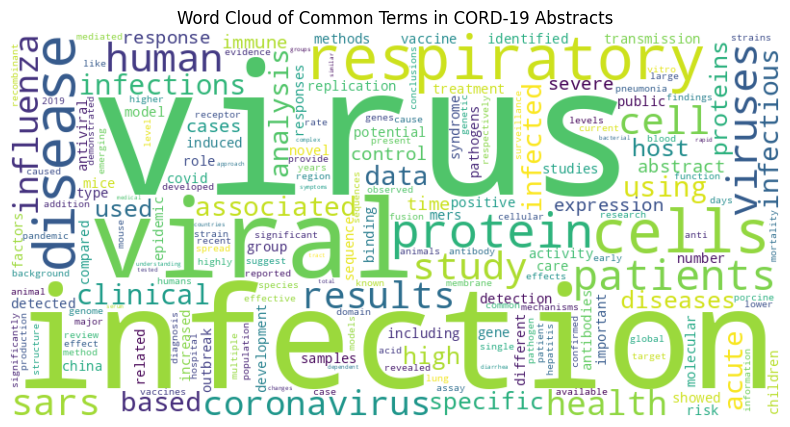

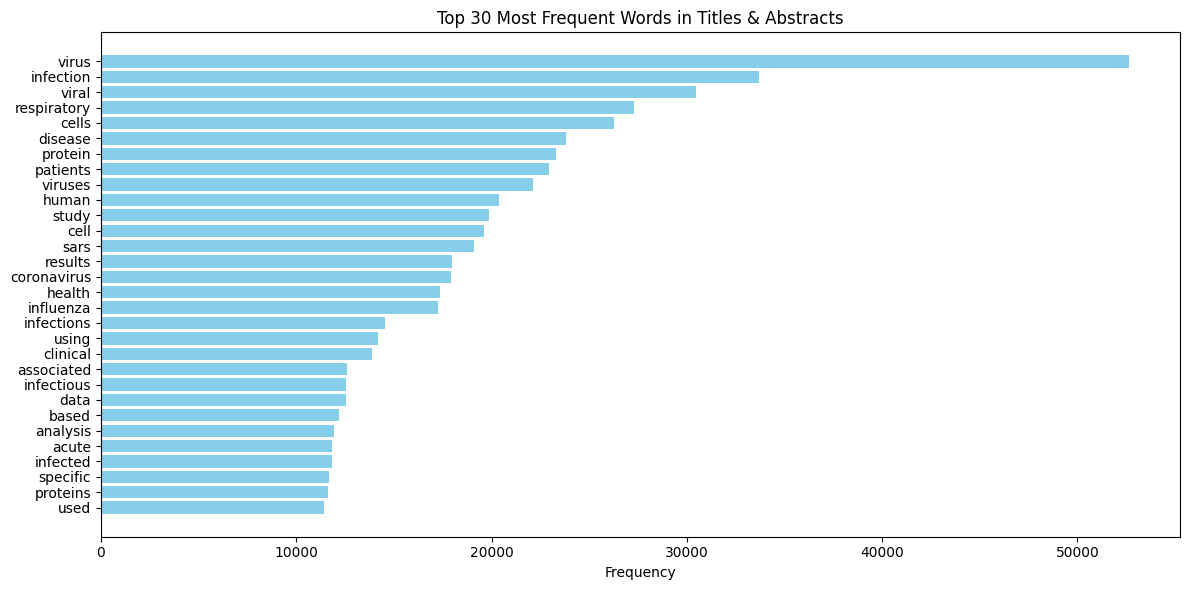

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from collections import Counter
import re
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

# Combine title and abstract fields
text_data = df["title"].fillna('') + ' ' + df["abstract"].fillna('')

# Simple preprocessing: remove numbers/symbols, lowercase, tokenize
words = []
for doc in text_data:
    cleaned = re.sub(r'\W+', ' ', doc.lower())  # remove punctuation
    tokens = cleaned.split()
    filtered = [word for word in tokens if word not in ENGLISH_STOP_WORDS and len(word) > 3]
    words.extend(filtered)

# Count word frequencies
word_freq = Counter(words)
top_words = word_freq.most_common(30)

# Visualization: Word Cloud
wc = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq)

plt.figure(figsize=(10, 5))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud of Common Terms in CORD-19 Abstracts")
plt.show()

# Bar Chart of Top Words
top_df = pd.DataFrame(top_words, columns=['Word', 'Frequency'])

plt.figure(figsize=(12, 6))
plt.barh(top_df['Word'][::-1], top_df['Frequency'][::-1], color='skyblue')
plt.title("Top 30 Most Frequent Words in Titles & Abstracts")
plt.xlabel("Frequency")
plt.tight_layout()
plt.show()


In [ ]:
df["title"] = df["title"].fillna("").str.lower()
df["abstract"] = df["abstract"].fillna("").str.lower()


smoking_keywords = ["smoking", "cigaratte", "tobacco", "nicotine", "vaping", "weed", "shisha"]
covid_keywords = ["covid", "coronavirus", "pandemic", "epidemic", "sars-cov-2", "novel coronavirus"]
cvd_keywords = [
    "cardiovascular", "heart disease", "coronary artery disease", "hypertension",
    "high blood pressure", "atherosclerosis", "myocardial infarction", "heart attack",
    "stroke", "angina", "arrhythmia", "heart failure", "ischemic heart disease",
    "cardiomyopathy", "ventricular", "cholesterol", "LDL", "HDL", "plaque buildup",
    "cardiac arrest", "thrombosis"
]

drinking_keywords = [
    "alcohol", "alcoholic", "drinking", "alcoholism", "binge drinking",
    "heavy drinking", "moderate drinking", "alcohol consumption", "ethanol",
    "beer", "wine", "liquor", "spirits", "vodka", "whiskey", "cocktail",
    "alcohol use", "alcohol abuse", "alcohol intake", "alcohol dependence",
    "hangover", "intoxication", "blood alcohol", "sobriety"
]
mental_health_keywords = [
    "mental health", "depression", "anxiety", "stress", "bipolar", "schizophrenia",
    "PTSD", "panic disorder", "OCD", "mental illness", "psychological", "therapy",
    "counseling", "suicidal", "suicide", "mood disorder", "psychosis", "insomnia",
    "emotional well-being", "cognitive behavioral therapy", "CBT"
]
nutrition_keywords = [
    "nutrition", "diet", "dietary", "calories", "vitamins", "minerals", "protein",
    "carbohydrates", "fat intake", "fiber", "sugar", "cholesterol", "omega-3",
    "saturated fat", "unsaturated fat", "micronutrients", "macronutrients",
    "plant-based diet", "keto", "Mediterranean diet", "DASH diet", "balanced diet",
    "food intake", "healthy eating", "dietary guidelines"
]
is_smoking_related = df["title"].str.contains("|".join(smoking_keywords)) | df["abstract"].str.contains("|".join(smoking_keywords))
is_covid_related = df["title"].str.contains("|".join(covid_keywords)) | df["abstract"].str.contains("|".join(covid_keywords))
is_cvd_related = df["title"].str.contains("|".join(cvd_keywords)) | df["abstract"].str.contains("|".join(cvd_keywords))
is_drinking_related = df["title"].str.contains("|".join(drinking_keywords)) | df["abstract"].str.contains("|".join(drinking_keywords))
is_mental_health_related = df["title"].str.contains("|".join(mental_health_keywords)) | df["abstract"].str.contains("|".join(mental_health_keywords))
is_nutrition_related = df["title"].str.contains("|".join(nutrition_keywords)) | df["abstract"].str.contains("|".join(nutrition_keywords))

filtered_df = df[
    is_covid_related & (
        is_smoking_related | is_drinking_related |
        is_cvd_related | is_mental_health_related | is_nutrition_related
    )
]

filtered_df.to_csv("filtered_data.csv", index=False)

print(f"found {len(filtered_df)} papers related to these keywords")

#filtered_df.head()

found 5522 papers related to these keywords


In [ ]:
print(df.columns.tolist())

['cord_uid', 'sha', 'source_x', 'title', 'doi', 'pmcid', 'pubmed_id', 'license', 'abstract', 'publish_time', 'authors', 'journal', 'Microsoft Academic Paper ID', 'WHO #Covidence', 'has_pdf_parse', 'has_pmc_xml_parse', 'full_text_file', 'url']


In [ ]:
df_filtered = pd.read_csv("filtered_data.csv")
#df_filtered.head()

df_filtered = df_filtered[df_filtered['full_text_file'].notnull()]
df_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4156 entries, 0 to 5521
Data columns (total 18 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   cord_uid                     4156 non-null   object 
 1   sha                          3950 non-null   object 
 2   source_x                     4156 non-null   object 
 3   title                        4156 non-null   object 
 4   doi                          4132 non-null   object 
 5   pmcid                        3446 non-null   object 
 6   pubmed_id                    3257 non-null   float64
 7   license                      4156 non-null   object 
 8   abstract                     4046 non-null   object 
 9   publish_time                 4156 non-null   object 
 10  authors                      4133 non-null   object 
 11  journal                      3742 non-null   object 
 12  Microsoft Academic Paper ID  84 non-null     float64
 13  WHO #Covidence         

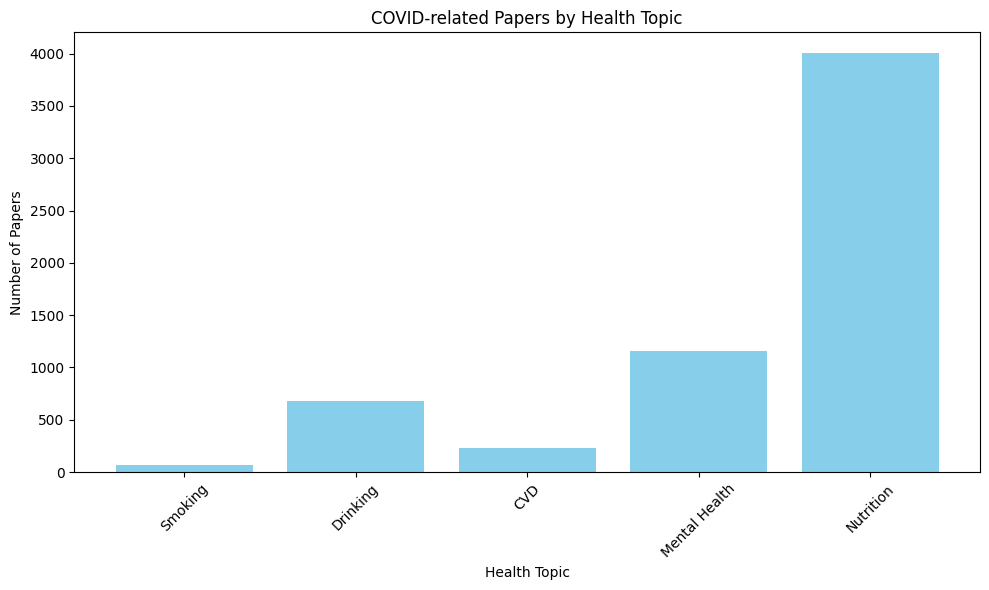

In [ ]:
import matplotlib.pyplot as plt

# Count how many papers match each secondary condition within COVID-related ones
counts = {
    "Smoking": (is_covid_related & is_smoking_related).sum(),
    "Drinking": (is_covid_related & is_drinking_related).sum(),
    "CVD": (is_covid_related & is_cvd_related).sum(),
    "Mental Health": (is_covid_related & is_mental_health_related).sum(),
    "Nutrition": (is_covid_related & is_nutrition_related).sum()
}

# Plot
plt.figure(figsize=(10, 6))
plt.bar(counts.keys(), counts.values(), color='skyblue')
plt.title("COVID-related Papers by Health Topic")
plt.ylabel("Number of Papers")
plt.xlabel("Health Topic")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

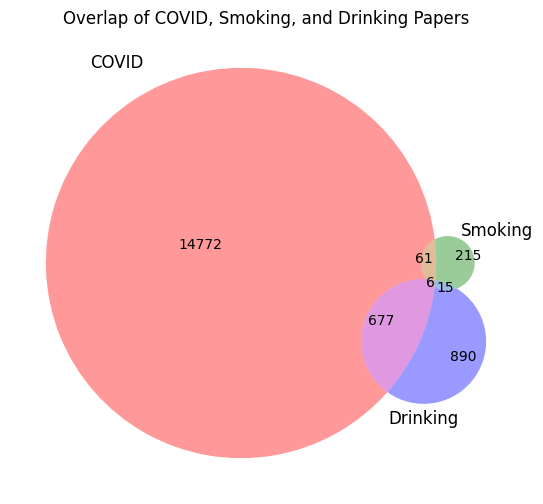

In [ ]:
# Validate that the boolean series for each category exist and are of the correct length
if not isinstance(is_covid_related, pd.Series) or len(is_covid_related) != len(df):
    print("Error: is_covid_related is not a valid pandas Series or its length doesn't match the DataFrame.")
elif not isinstance(is_smoking_related, pd.Series) or len(is_smoking_related) != len(df):
    print("Error: is_smoking_related is not a valid pandas Series or its length doesn't match the DataFrame.")
elif not isinstance(is_drinking_related, pd.Series) or len(is_drinking_related) != len(df):
    print("Error: is_drinking_related is not a valid pandas Series or its length doesn't match the DataFrame.")
else:
    # Calculate the subset sizes
    try:
        subset_sizes = (
            int((is_covid_related & ~is_smoking_related & ~is_drinking_related).sum()),
            int((is_smoking_related & ~is_covid_related & ~is_drinking_related).sum()),
            int((is_covid_related & is_smoking_related & ~is_drinking_related).sum()),
            int((is_drinking_related & ~is_covid_related & ~is_smoking_related).sum()),
            int((is_covid_related & ~is_smoking_related & is_drinking_related).sum()),
            int((is_smoking_related & is_drinking_related & ~is_covid_related).sum()),
            int((is_covid_related & is_smoking_related & is_drinking_related).sum()),
        )

        # Check if all subset sizes are non-negative
        if all(size >= 0 for size in subset_sizes):
            # Proceed with plotting the Venn diagram
            plt.figure(figsize=(8, 6))
            venn3(subsets=subset_sizes, set_labels=('COVID', 'Smoking', 'Drinking'))
            plt.title("Overlap of COVID, Smoking, and Drinking Papers")
            plt.show()
        else:
            print("Error: Subset sizes for the Venn diagram cannot be negative.")

    except Exception as e:
        print(f"An error occurred while calculating subset sizes or plotting the Venn diagram: {e}")

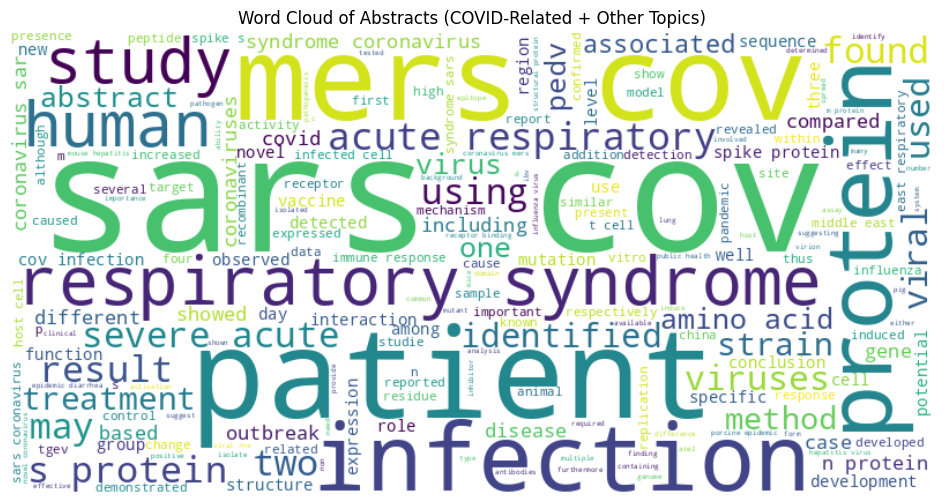

In [ ]:
from wordcloud import WordCloud

# Combine all abstracts into one string
text = " ".join(filtered_df["abstract"].dropna().tolist())

wc = WordCloud(width=800, height=400, background_color='white').generate(text)

plt.figure(figsize=(12, 6))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.title("Word Cloud of Abstracts (COVID-Related + Other Topics)")
plt.show()


In [ ]:
import unittest
from io import BytesIO

class TestWordCloudGeneration(unittest.TestCase):

  def test_wordcloud_generation(self):
    # Create a dummy DataFrame that mimics the structure of filtered_df
    data = {'abstract': ['This is a sample abstract about covid and smoking.',
                         'Another abstract discussing drinking and covid-19.',
                         'A third abstract with no relevant keywords.',
                         None, # Include a None value to test dropna()
                         'This is an abstract about covid, smoking, and drinking.']}
    filtered_df_dummy = pd.DataFrame(data)

    # Combine all abstracts into one string
    text = " ".join(filtered_df_dummy["abstract"].dropna().tolist())

    # Assert that the combined text is a string and is not empty
    self.assertIsInstance(text, str)
    if not filtered_df_dummy["abstract"].dropna().empty:
        self.assertGreater(len(text), 0, "Combined text should not be empty if there are non-null abstracts")

    # Test if the WordCloud constructor and generate method work without errors
    try:
        wc = WordCloud(width=800, height=400, background_color='white').generate(text)
    except Exception as e:
        self.fail(f"WordCloud generation failed: {e}")

    # Assert that the generated object is a WordCloud instance
    self.assertIsInstance(wc, WordCloud)

    # Assert that the word cloud has some words (if the text was not empty)
    if text:
        # Check if the internal word_counts attribute is populated
        self.assertGreater(len(wc.words_), 0, "WordCloud should contain words if the input text was not empty")

    # Test the plotting part - mainly to ensure it doesn't raise errors
    try:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.imshow(wc, interpolation='bilinear')
        ax.axis("off")
        ax.set_title("Word Cloud of Abstracts (COVID-Related + Other Topics)")

        # Save the figure to a buffer instead of showing it, to avoid interfering with the test runner
        buf = BytesIO()
        plt.savefig(buf, format='png')
        buf.close()
        plt.close(fig) # Close the figure to free memory

    except Exception as e:
        self.fail(f"WordCloud plotting failed: {e}")

if __name__ == '__main__':
    unittest.main(argv=['first-arg-is-ignored'], exit=False)

.
----------------------------------------------------------------------
Ran 1 test in 0.384s

OK


In [ ]:
from llama_index.llms.huggingface import HuggingFaceLLM
from llama_index.embeddings.huggingface import HuggingFaceEmbedding # Import HuggingFaceEmbedding


In [ ]:
embed_model = HuggingFaceEmbedding(model_name="sentence-transformers/all-miniLM-L6-v2")
Settings.embed_model = embed_model

llm = HuggingFaceLLM(
    model_name="colesmcintosh/Llama-3.2-1B-Instruct-Mango",
    tokenizer_name="colesmcintosh/Llama-3.2-1B-Instruct-Mango",
    context_window=2048,
    max_new_tokens=256,
    generate_kwargs={"temperature": 0.7, "do_sample": True},
)

Settings.llm = llm

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

adapter_config.json:   0%|          | 0.00/738 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.52k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/1.03G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/234 [00:00<?, ?B/s]

adapter_model.safetensors:   0%|          | 0.00/45.1M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/55.4k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.2M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/454 [00:00<?, ?B/s]

In [ ]:
documents = [Document(text=str(row["abstract"])) for _, row in df_filtered.iterrows() if pd.notna(row["abstract"])]
index_storage_dir = "/content/drive/My Drive/index_storage"

if os.path.exists(index_storage_dir):
    print("Index storage directory already exists. Loading index from storage...")
    storage_context = StorageContext.from_defaults(persist_dir=index_storage_dir)
    index = load_index_from_storage(storage_context)
else:
    print("Creating new index...")
    index = VectorStoreIndex.from_documents(documents)
    index.storage_context.persist(persist_dir=index_storage_dir)

Index storage directory already exists. Loading index from storage...


In [ ]:
#from llama_index.memory import ChatMemoryBuffer

chat_engine = index.as_chat_engine(
       chat_mode="context",
       memory=ChatMemoryBuffer.from_defaults(token_limit=32000),
       system_prompt=(
        "You are a Covid chatbot, able to have normal interactions. You only answer based on Metadata dataset."
    )
)

In [ ]:
!pip install gradio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.2/54.2 MB 16.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 323.1/323.1 kB 29.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.5/11.5 MB 129.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 5.7 MB/s eta 0:00:00


In [ ]:
import gradio as gr

def respond(query):
  if query.lower() == "exit" or query.lower() == "quit":
      return "Exiting chat..."
  response = chat_engine.chat(query)
  return f"Agent: {response.response}"

iface = gr.Interface(
    fn=respond,
    inputs=gr.Textbox(lines=2, placeholder="Enter your query here..."),
    outputs="text",
    title="Covid Chatbot",
    description="Ask questions about COVID and related topics based on the Covid Metadata dataset.",
    theme="compact",  # Optional: Choose a different theme
    allow_flagging="never"
)

iface.launch(share=True)


/usr/local/lib/python3.11/dist-packages/gradio/blocks.py:1153: UserWarning: Cannot load compact. Caught Exception: 404 Client Error: Not Found for url: https://huggingface.co/api/spaces/compact (Request ID: Root=1-6835804f-7d670f03172d599b0ef1590a;4454f5c7-89e5-452a-b930-18e44a34fab2)

Sorry, we can't find the page you are looking for.
  warnings.warn(f"Cannot load {theme}. Caught Exception: {str(e)}")
/usr/local/lib/python3.11/dist-packages/gradio/interface.py:416: UserWarning: The `allow_flagging` parameter in `Interface` is deprecated.Use `flagging_mode` instead.
  warnings.warn(


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://015e9d21a3abcd7ea6.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
